# ボケ判定AIを作ろう！-チュートリアル1
このnotebookは、Nishikaコンペティション [ボケ判定AIを作ろう！](https://www.nishika.com/competitions/) のチュートリアルです。

「ボケて」データを用いて、画像データと文章からそのボケてが面白いか面白くないかを予測することをテーマとしています。

このNotebookでは、画像とテキストそれぞれの特徴量生成を以下のような方法で行っていきます。

- CNNモデルを用いた画像データの特徴量化
- BERTモデルを用いたテキストデータの特徴量化

特徴量の作成では、テキストと画像それぞれ別々で作成していますので、画像データとテキストデータを組み合わせた特徴量を入れることで精度向上が見込めるかも知れませんので、いろいろと試していただければと思います。

| 要素 | 説明 |
| ---- | ---- |
|id | ID|
|odai_photo_file_name | ボケてのお題画像|
|text | ボケての文章|
|is_laugh | 面白さ（面白い：１、面白くない：０）|


ディレクトリ構成は以下のように設定します

```
├── train.zip
│ ├── xxx.jpg
│ └── yyy.jpg
├── test.zip
│ ├── xxx.jpg
│ └── yyy.jpg
├── train.csv
├── test.csv
├── sample_submission.csv
└── submission.csv(今回のbaselineで生成されるsubmissionファイル)


```

### setting
ページ上部の「ランタイム」>「ランタイムのタイプを変更」から「GPU」「ハイメモリ」を選択

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi

Tue Oct  4 11:01:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Library

In [3]:
!pip install timm
import timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install --quiet transformers==4.18.0
!pip install --quiet tokenizers==0.12.1
!pip install --quiet sentencepiece
!pip install --quiet japanize-matplotlib
!pip install transformers fugashi ipadic >> /dev/null

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch


from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import sys
import os
import re
import random

from time import time
from tqdm import tqdm

from contextlib import contextmanager
import lightgbm as lgb

import re
import requests
import unicodedata
import nltk
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
nltk.download(['wordnet', 'stopwords', 'punkt'])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Setting

In [6]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(42)

In [7]:
INPUT = "/content/drive/MyDrive/nishika/" # 所望のディレクトリに変更してください。
train_image_path = "/content/drive/MyDrive/nishika/train/"
test_image_path = "/content/drive/MyDrive/nishika/test/"

# Read Data
学習データと推論データについて、目的変数の分布などを確認していきます。

In [8]:
train_df = pd.read_csv(os.path.join(INPUT, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT, "test.csv"))
submission_df = pd.read_csv(os.path.join(INPUT, "sample_submission.csv"))

In [9]:
print(f"train_data: {train_df.shape}")
display(train_df.head())

print(f"test_data: {test_df.shape}")
display(test_df.head())

train_data: (24962, 4)


,id,odai_photo_file_name,text,is_laugh
0,ge5kssftl,9fkys1gb2r.jpg,君しょっちゅうソレ自慢するけど、ツムジ２個ってそんなに嬉しいのかい？,0
1,r7sm6tvkj,c6ag0m1lak.jpg,これでバレない？授業中寝てもバレない？,0
2,yp5aze0bh,whtn6gb9ww.jpg,「あなたも感じる？」\n『ああ…、感じてる…』\n「後ろに幽霊いるよね…」\n『女のな…』,0
3,ujaixzo56,6yk5cwmrsy.jpg,大塚愛聞いてたらお腹減った…さく、らんぼと牛タン食べたい…,0
4,7vkeveptl,0i9gsa2jsm.jpg,熊だと思ったら嫁だった,0


test_data: (6000, 3)


,id,odai_photo_file_name,text
0,rfdjcfsqq,nc1kez326b.jpg,僕のママ、キャラ弁のゆでたまごに８時間かかったんだ
1,tsgqmfpef,49xt2fmjw0.jpg,かわいいが作れた！
2,owjcthkz2,9dtscjmyfh.jpg,来世の志茂田景樹
3,rvgaocjyy,osa3n56tiv.jpg,ちょ、あの、オカン、これ水風呂やねんけど、なんの冗談??
4,uxtwu5i69,yb1yqs4pvb.jpg,「今日は皆さんにザリガニと消防車の違いを知ってもらいたいと思います」『どっちも同じだろ。両方...


# Create Image Features

ボケてというものは、画像と文章の組み合わせで面白さを表現しているので、以下にして画像のデータと文章のデータをモデルに学習させるかがポイントになってくるかと思います。

画像のデータを特徴量として用いるために、今回はDenseNet121の学習済みモデルを用います。

In [10]:
from tqdm import tqdm, tqdm_notebook

In [11]:
import torch.nn as nn
from torchvision import transforms
from pathlib import Path

from torch.utils.data import DataLoader, Dataset

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
model_name = "vit_large_patch16_224"
data_config = timm.data.resolve_data_config({}, model=model_name, verbose=True)

In [14]:
"""
class Net(nn.Module):
    def __init__(self, n_out):
        super(Net, self).__init__()
        #モデルの定義
        self.net = timm.create_model(model_name, pretrained=True)

        #self.in_features = self.net.num_features,
        #最終層の再定義
        #self.head = nn.Sequential(
          #nn.Linear(self.in_features,96),
          #nn.ReLU(),nn.Dropout(0.2),
        self.net.classifier = nn.Linear(1280,n_out)
          
          #nn.AvgPool2d()(1280),
          #nn.Lambda(lambda x: torch.unsqueeze(x,axis = -1))(1280),
          #nn.AvgPool1d(4)(1280),
          #nn.Lambda(lambda x: x[:,:,0])(n_out)
          
        #)

    def forward(self, x):
      return self.net(x)
"""

'\nclass Net(nn.Module):\n    def __init__(self, n_out):\n        super(Net, self).__init__()\n        #モデルの定義\n        self.net = timm.create_model(model_name, pretrained=True)\n\n        #self.in_features = self.net.num_features,\n        #最終層の再定義\n        #self.head = nn.Sequential(\n          #nn.Linear(self.in_features,96),\n          #nn.ReLU(),nn.Dropout(0.2),\n        self.net.classifier = nn.Linear(1280,n_out)\n          \n          #nn.AvgPool2d()(1280),\n          #nn.Lambda(lambda x: torch.unsqueeze(x,axis = -1))(1280),\n          #nn.AvgPool1d(4)(1280),\n          #nn.Lambda(lambda x: x[:,:,0])(n_out)\n          \n        #)\n\n    def forward(self, x):\n      return self.net(x)\n'

In [15]:
class Net(nn.Module):
     def __init__(self,n_out):
        super().__init__()
        #モデルの定義
        self.net = timm.create_model(model_name, pretrained=True, num_classes=0)

        self.in_features = self.net.num_features
        #最終層の再定義
        self.head = nn.Sequential(
          nn.Linear(self.in_features,1280),
          nn.ReLU(),nn.Dropout(),
          nn.Linear(1280,n_out))
          
          #nn.AvgPool2d()(self.in_features),
          #nn.Lambda(lambda x: torch.unsqueeze(x,axis = -1)),
          #nn.AvgPool1d(4),
          #nn.Lambda(lambda x: x[:,:,0]))

     def forward(self, x):
      h = self.net(x)
      y = self.head(h)

      return y

In [16]:
model = Net(512)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [17]:
transform = transforms.Compose(
    [
        transforms.Resize(225),  
        transforms.CenterCrop(224),
        transforms.ToTensor(),  # テンソルにする。
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # 標準化する。
    ]
)

In [18]:
def _get_img_paths(img_dir):
    img_dir = Path(img_dir)
    img_extensions = [".jpg"]
    img_paths = [str(p) for p in img_dir.iterdir() if p.suffix in img_extensions]
    img_paths.sort()

    return img_paths


class ImageFolder(Dataset):
    def __init__(self, img_dir,transform):
        # 画像ファイルのパス一覧を取得する。
        self.img_paths = _get_img_paths(img_dir)
        self.transform = transform

    def __getitem__(self, index):
        path = self.img_paths[index]
        img = Image.open(path).convert("RGB")
        inputs = self.transform(img)

        return {"image": inputs, "path": path}

    def __len__(self):
        return len(self.img_paths)

In [19]:
# Dataset を作成する。
dstrain = ImageFolder("/content/drive/MyDrive/nishika/train",transform)

In [20]:
import glob
import itertools


def get_images_features(dataset):
    image_features = []
    
    with torch.no_grad():
        for batch in tqdm(DataLoader(dataset, batch_size=17)):
            inputs = batch["image"].to(device)
            outputs = model(inputs)

            image_features.append(outputs)

    return torch.cat(image_features).cpu().numpy()

In [21]:
train_image_features = get_images_features(dstrain)

100%|██████████| 1469/1469 [07:53<00:00,  3.10it/s]


In [22]:
image_feature = pd.DataFrame.from_dict(train_image_features, orient='columns').add_prefix("vit_large_patch16_224_").reset_index()
image_feature.rename(columns={"columns":"odai_photo_file_name"}, inplace=True)

In [23]:
image_feature = image_feature.drop(["index"], axis=1)

In [24]:
print(image_feature)

       vit_large_patch16_224_0  vit_large_patch16_224_1  \
0                    -0.174948                 1.216538   
1                     0.759446                 0.550291   
2                     0.445224                -0.187247   
3                    -0.329393                 0.633074   
4                     0.406402                 1.002488   
...                        ...                      ...   
24957                 1.024891                -0.834444   
24958                -0.776498                 0.833142   
24959                -0.751882                 1.186205   
24960                 0.502788                 2.710541   
24961                -1.214408                 1.231479   

       vit_large_patch16_224_2  vit_large_patch16_224_3  \
0                    -2.196662                 0.005932   
1                    -1.803098                -1.484083   
2                    -1.625515                -1.966000   
3                    -1.377089                -1.452802

In [25]:
# trainのデータに結合します。
train_df = pd.concat([train_df, image_feature],axis=1)

In [26]:
train_df.shape

(24962, 516)

In [27]:
print(train_df)

              id odai_photo_file_name  \
0      ge5kssftl       9fkys1gb2r.jpg   
1      r7sm6tvkj       c6ag0m1lak.jpg   
2      yp5aze0bh       whtn6gb9ww.jpg   
3      ujaixzo56       6yk5cwmrsy.jpg   
4      7vkeveptl       0i9gsa2jsm.jpg   
...          ...                  ...   
24957  xa2nruec1       5ctq9ohpge.jpg   
24958  dl8r1idfv       dcj9pepjwf.jpg   
24959  kabzw7bxm       ks04y4iy7i.jpg   
24960  4blagy0gf       cgfkktchbz.jpg   
24961  of5eofmq6       jwulli1cmi.jpg   

                                                text  is_laugh  \
0                 君しょっちゅうソレ自慢するけど、ツムジ２個ってそんなに嬉しいのかい？         0   
1                                これでバレない？授業中寝てもバレない？         0   
2      「あなたも感じる？」\n『ああ…、感じてる…』\n「後ろに幽霊いるよね…」\n『女のな…』         0   
3                     大塚愛聞いてたらお腹減った…さく、らんぼと牛タン食べたい…          0   
4                                        熊だと思ったら嫁だった         0   
...                                              ...       ...   
24957                            え、いいんすか？マジっす

In [28]:
# Dataset を作成する。
dstest = ImageFolder("/content/drive/MyDrive/nishika/test",transform)

In [29]:
test_image_features = get_images_features(dstest)

100%|██████████| 353/353 [01:53<00:00,  3.12it/s]


In [30]:
image_feature = pd.DataFrame.from_dict(test_image_features, orient='columns').add_prefix("vit_large_patch16_224_").reset_index()
image_feature.rename(columns={"columns":"odai_photo_file_name"}, inplace=True)

In [31]:
image_feature = image_feature.drop(["index"], axis=1)

In [32]:
# trainのデータに結合します。
test_df = pd.concat([test_df, image_feature],axis=1)

In [33]:
test_df.shape

(6000, 515)

# Data Split

In [34]:
train_df.to_csv('/content/drive/MyDrive/nishika/embeded/embedding_train_image_timm_dm_vit_large_patch16_224.csv')

In [35]:
test_df.to_csv('/content/drive/MyDrive/nishika/embeded/embedding_test_image_timm_dm_vit_large_patch16_224.csv')

In [36]:
train_df["text_len"] = train_df["text"].str.len()
test_df["text_len"] = test_df["text"].str.len()

In [37]:
# 学習データと評価データに分割します
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["is_laugh"])

train_y = train_df["is_laugh"]
train_x = train_df.drop(["id", "odai_photo_file_name", "text","is_laugh"], axis=1)

valid_y = valid_df["is_laugh"]
valid_x = valid_df.drop(["id", "odai_photo_file_name", "text","is_laugh"], axis=1)

test_x = test_df.drop(["id", "odai_photo_file_name", "text"], axis=1)

In [38]:
print(train_x.shape)
print(valid_x.shape)

(19969, 513)
(4993, 513)


# Model

In [39]:
lgbm_params = {  
    "n_estimators": 20000,
    "objective": 'binary',
    "learning_rate": 0.01,
    "num_leaves": 32,
    "random_state": 71,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .8,
    "reg_lambda": 5,
    "max_depth":9,
    }

lgtrain = lgb.Dataset(train_x, train_y)
lgvalid = lgb.Dataset(valid_x, valid_y)

lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=10000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=100,
    verbose_eval=100
)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	train's binary_logloss: 0.653686	valid's binary_logloss: 0.674765
[200]	train's binary_logloss: 0.629966	valid's binary_logloss: 0.670354
[300]	train's binary_logloss: 0.610511	valid's binary_logloss: 0.669692
[400]	train's binary_logloss: 0.592992	valid's binary_logloss: 0.670154
Early stopping, best iteration is:
[306]	train's binary_logloss: 0.6094	valid's binary_logloss: 0.669638


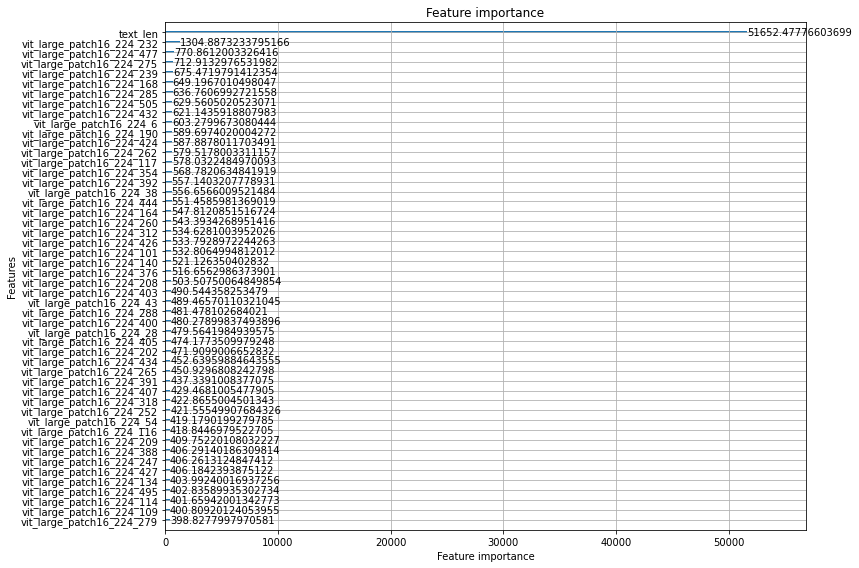

In [40]:
# 特徴量の重要度を可視化。
lgb.plot_importance(lgb_clf, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.show()

In [41]:
# 評価指標はlog lossだが、accuracyも見てみる

val_pred = lgb_clf.predict(valid_x, num_iteration=lgb_clf.best_iteration)
val_pred_max = np.round(lgb_clf.predict(valid_x)).astype(int)  # クラスに分類
accuracy = sum(valid_y == val_pred_max) / len(valid_y)
print(accuracy)

0.5870218305627879


Text(0.5, 51.0, 'Predict')

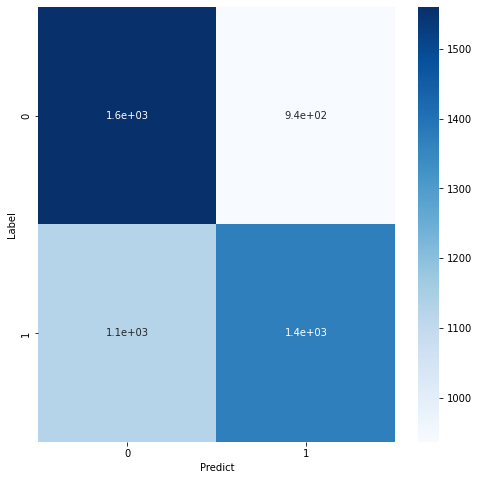

In [42]:
_conf_options = {"normalize": None,}
_plot_options = {
        "cmap": "Blues",
        "annot": True
    }

conf = confusion_matrix(y_true=valid_y,
                        y_pred=val_pred_max,
                        **_conf_options)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf, ax=ax, **_plot_options)
ax.set_ylabel("Label")
ax.set_xlabel("Predict")

# Predict

In [43]:
test_pred = lgb_clf.predict(test_x, num_iteration=lgb_clf.best_iteration)

In [44]:
submission_df["is_laugh"] = test_pred
submission_df.head()

,id,is_laugh
0,rfdjcfsqq,0.528760
1,tsgqmfpef,0.404427
2,owjcthkz2,0.363496
3,rvgaocjyy,0.492799
4,uxtwu5i69,0.739498


In [45]:
submission_df.to_csv(('/content/drive/MyDrive/nishika/sub.csv'), index=False)

実際に提出して、スコアを確認してみましょう。  精度向上に向けて様々なアイディアがあるかと思いますので、ぜひいろいろとトライしていただければと思います！

- 異なる学習済みモデルでの特徴量化
- 画像の状況とボケての文章との解離具合を測定する
- 説明文口調とセリフ口調の分類をしてみる。
- 画像に何が写っているかを検出し、特徴量に加えてみる（人が写っている。動物が写っている）


https://lab.mo-t.com/blog/kaggle-shopee
前処理については今回は気にしない。最終的なLightgbmにぶっこむ特徴量を増やして選別する方針でいく。
エンベッディングした結果は保存する。
最初は画像は画像、テキストはテキストでエンベッディングする。
画像のArcFaceちょっとめんどい、実装できそうならやる
knn(k=50)を使って、画像、テキストの分類自体はする。
https://www.kaggle.com/code/jyotmakadiya/shopee-groupkfolds-effnetb1-and-tfidf-or-bert

基本はエンベッディングしたものを使う。
プラスで、特徴量を足してみる。
乖離具合ってどうやって測定するのか
・長文？なんかキーになる話がある？画像と関係？わからん
・ボケのデザインパターン/ジョナサン・ハイト
・既知未知判定ってどうやってやるんだ・・・
・ポジネガ距離はおもろい。
あえて正しいこととは逆なことをして、許されるライン的な話。
→単純にえぐい言葉やえぐさを分類？なんかいいのないかな。
説明文とセリフ文→なんかいい楽な分類ないかな、なかったら頑張る。
画像に何が写っているか→うーん、手動しかないかも。